# Libraries

In [1]:
import requests
import pandas as pd
import json
from typing import Optional, Dict, Any, List
from missingno import matrix
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

## No column display limit

In [2]:
pd.set_option('display.max_columns', None)

# Data extraction

## API setup

In [3]:
class LongBeachAnimalShelterAPI:
    """
    A Python client for extracting data from the Long Beach Animal Shelter API
    using the Opendatasoft Explore API v2.1
    """
    
    def __init__(self):
        self.base_url = "https://longbeach.opendatasoft.com/api/explore/v2.1"
        self.dataset_id = "animal-shelter-intakes-and-outcomes"
        
    def get_all_records(self, 
                       select: Optional[str] = None,
                       where: Optional[str] = None,
                       order_by: Optional[str] = None) -> pd.DataFrame:
        """
        Extract all records from the animal shelter dataset without limits.
        
        Args:
            select: Fields to select (default: all fields)
            where: Filter conditions using ODSQL syntax
            order_by: Order by clause
            
        Returns:
            pandas.DataFrame with all records
        """
        
        all_records = []
        offset = 0
        limit = 100  # Maximum allowed per request
        
        while True:
            # Build API request
            url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/records"
            
            params = {
                'limit': limit,
                'offset': offset
            }
            
            # Add optional parameters
            if select:
                params['select'] = select
            if where:
                params['where'] = where
            if order_by:
                params['order_by'] = order_by
                
            try:
                response = requests.get(url, params=params)
                response.raise_for_status()
                
                data = response.json()
                
                # Extract records from response
                records = data.get('results', [])
                
                if not records:
                    break
                    
                all_records.extend(records)
                
                # Check if we've retrieved all records
                total_count = data.get('total_count', 0)
                if len(all_records) >= total_count:
                    break
                    
                # Move to next batch
                offset += limit
                
                print(f"Retrieved {len(all_records)} of {total_count} records...")
                
            except requests.RequestException as e:
                print(f"Error fetching data: {e}")
                break
                
        # Convert to DataFrame
        df = pd.DataFrame(all_records)
        print(f"Successfully retrieved {len(df)} total records")
        
        return df
    
    def get_dataset_info(self) -> Dict[str, Any]:
        """
        Get metadata about the dataset including field information.
        
        Returns:
            Dictionary with dataset metadata
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as e:
            print(f"Error fetching dataset info: {e}")
            return {}
    
    def export_to_csv(self, 
                     filename: str = "animal_shelter_data.csv",
                     select: Optional[str] = None,
                     where: Optional[str] = None) -> bool:
        """
        Export data directly to CSV using the API's export endpoint.
        
        Args:
            filename: Output CSV filename
            select: Fields to select
            where: Filter conditions
            
        Returns:
            True if successful, False otherwise
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/exports/csv"
        
        params = {'limit': -1}  # -1 means no limit for exports
        
        if select:
            params['select'] = select
        if where:
            params['where'] = where
            
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Data exported to {filename}")
            return True
            
        except requests.RequestException as e:
            print(f"Error exporting data: {e}")
            return False

## Run

In [4]:
if __name__ == "__main__":
    
    # Initialize the API client
    api = LongBeachAnimalShelterAPI()
    
    # Example 1: Get all records
    print("Fetching all animal shelter records...")
    df = api.get_all_records()
    print(f"Retrieved {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    
    
    # Example 5: Export directly to CSV
    print("\nExporting all data to CSV...")
    api.export_to_csv("longbeach_animal_shelter_complete.csv")
    
    
    # Display sample data
    if not df.empty:
        print("\nSample data:")
        print(df.head())

Fetching all animal shelter records...
Retrieved 100 of 31937 records...
Retrieved 200 of 31937 records...
Retrieved 300 of 31937 records...
Retrieved 400 of 31937 records...
Retrieved 500 of 31937 records...
Retrieved 600 of 31937 records...
Retrieved 700 of 31937 records...
Retrieved 800 of 31937 records...
Retrieved 900 of 31937 records...
Retrieved 1000 of 31937 records...
Retrieved 1100 of 31937 records...
Retrieved 1200 of 31937 records...
Retrieved 1300 of 31937 records...
Retrieved 1400 of 31937 records...
Retrieved 1500 of 31937 records...
Retrieved 1600 of 31937 records...
Retrieved 1700 of 31937 records...
Retrieved 1800 of 31937 records...
Retrieved 1900 of 31937 records...
Retrieved 2000 of 31937 records...
Retrieved 2100 of 31937 records...
Retrieved 2200 of 31937 records...
Retrieved 2300 of 31937 records...
Retrieved 2400 of 31937 records...
Retrieved 2500 of 31937 records...
Retrieved 2600 of 31937 records...
Retrieved 2700 of 31937 records...
Retrieved 2800 of 31937 r

In [5]:
df = pd.read_csv("longbeach_animal_shelter_complete.csv", sep=None, engine='python')

## Data info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31937 entries, 0 to 31936
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ﻿animal_id         31937 non-null  object 
 1   animal_name        18934 non-null  object 
 2   animal_type        31937 non-null  object 
 3   primary_color      31937 non-null  object 
 4   secondary_color    15217 non-null  object 
 5   sex                31937 non-null  object 
 6   dob                27946 non-null  object 
 7   intake_date        31937 non-null  object 
 8   intake_cond        31937 non-null  object 
 9   intake_type        31937 non-null  object 
 10  intake_subtype     31523 non-null  object 
 11  reason             2172 non-null   object 
 12  outcome_date       31769 non-null  object 
 13  crossing           31937 non-null  object 
 14  jurisdiction       31937 non-null  object 
 15  outcome_type       31763 non-null  object 
 16  outcome_subtype    283

## Data preview

In [7]:
df.head()

,﻿animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
0,A705745,*OAKLEY,DOG,GRAY,TRICOLOR,Neutered,2021-08-30,2023-08-30,NORMAL,STRAY,OTC,NaN,2023-09-03,+2400 BLK E 15TH LONG BEACH CA 90804,LONG BEACH,ADOPTION,NaN,33.786225,-118.163308,Alive on Intake,False,1,"33.7862248, -118.1633079"
1,A683199,NaN,REPTILE,BROWN,NaN,Unknown,NaN,2022-09-06,NORMAL,STRAY,FIELD,NaN,2022-09-19,"0 BLK ORIZABA AVE, LONG BEACH, CA 90803",LONG BEACH,RESCUE,SC REPTILE,33.762118,-118.157944,Alive on Intake,False,1,"33.7621185, -118.1579439"
2,A697238,MIS,CAT,BRN TABBY,WHITE,Spayed,2023-03-06,2023-04-21,UNDER AGE/WEIGHT,STRAY,FIELD,NaN,2023-04-22,"0 BLOCK 55TH ST, LONG BEACH CA, 90805",LONG BEACH,ADOPTION,WEB,33.855923,-118.197177,Alive on Intake,False,1,"33.8559234, -118.1971768"
3,A710397,*CAMMIE,DOG,BLACK,BROWN,Female,2022-11-12,2023-11-12,NORMAL,WELFARE SEIZED,POLICE,NaN,2023-12-15,"00 39TH PL, LONG BEACH CA",LONG BEACH,ADOPTION,NaN,33.760205,-118.147768,Alive on Intake,False,1,"33.760205, -118.1477682"
4,A738927,KITTEN 5,CAT,GRAY,WHITE,Female,2025-02-03,2025-04-03,NORMAL,STRAY,OTC,NaN,2025-04-06,"00 BLK 53RD ST, LONG BEACH, CA 90805",LONG BEACH,RESCUE,OUTRCHPAWS,33.852387,-118.195857,Alive on Intake,False,1,"33.8523872, -118.1958567"


## Data format change for pandas

In [8]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '') # Removing whitespaces in column names

## Duplicates

In [9]:
# Check for duplicates by animal_id
df[df.duplicated('animal_id', keep=False)]

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
3,A710397,*CAMMIE,DOG,BLACK,BROWN,Female,2022-11-12,2023-11-12,NORMAL,WELFARE SEIZED,POLICE,NaN,2023-12-15,"00 39TH PL, LONG BEACH CA",LONG BEACH,ADOPTION,NaN,33.760205,-118.147768,Alive on Intake,False,1,"33.760205, -118.1477682"
7,A604840,GOLIATH,DOG,TAN,WHITE,Neutered,2015-03-15,2019-08-04,NORMAL,STRAY,FIELD,NaN,2019-08-11,"00 BLK E 68TH ST, LONG BEACH, CA 90805",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.877607,-118.203483,Alive on Intake,False,1,"33.8776071, -118.2034825"
30,A723857,JAMES BOND,DOG,BLACK,NaN,Male,2012-07-03,2024-07-17,ILL SEVERE,OWNER SURRENDER,OTC,ILL,2024-07-17,00 S ATLANTIC AVE LONG BEACH CA 90802,LONG BEACH,EUTHANASIA,ILL SEVERE,33.766432,-118.185045,Alive on Intake,True,0,"33.7664319, -118.1850452"
55,A635485,*HANNAH,DOG,BROWN,BLACK,Female,2012-05-24,2019-11-24,BEHAVIOR MILD,OWNER SURRENDER,OTC,AGG ANIMAL,2019-12-22,"100 54TH PL, LONG BEACH, CA 90803",DISTRICT3,RESCUE,LIVELOVE,33.755081,-118.132210,Alive on Intake,False,1,"33.7550806, -118.1322096"
91,A606022,BABY,DOG,BLACK,WHITE,Male,2017-06-09,2019-06-19,BEHAVIOR MODERATE,STRAY,FIELD,NaN,2019-06-22,"100 BLK CHERRY AVE, LONG BEACH, CA 90802",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.765221,-118.167597,Alive on Intake,False,1,"33.7652208, -118.1675969"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31877,A614165,HARLEY,DOG,GRAY,NaN,Neutered,2011-04-18,2019-04-17,NORMAL,STRAY,OTC,NaN,2019-04-18,"W ARLINGTON ST / WEBSTER AVE, LONG BEACH, CA 9...",LONG BEACH,RETURN TO OWNER,WALKIN,33.821961,-118.220048,Alive on Intake,False,1,"33.8219607, -118.220048"
31899,A593031,SHADOW,DOG,BROWN,NaN,Neutered,2016-07-06,2017-07-09,NORMAL,STRAY,FIELD,NaN,2017-07-09,"W WARDLOW RD / PACIFIC PL, LONG BEACH, CA 90806",LONG BEACH,RETURN TO OWNER,NaN,33.818908,-118.195846,Alive on Intake,False,1,"33.8189077, -118.1958459"
31902,A460119,NELLY,DOG,BLACK,NaN,Female,2008-08-28,2018-02-03,NORMAL,STRAY,FIELD,NaN,2018-02-07,"W WILLOW ST / EASY AVE, LONG BEACH, CA 90810",LONG BEACH,RETURN TO OWNER,WALKIN,33.804343,-118.210022,Alive on Intake,False,1,"33.8043432, -118.2100224"
31910,A617167,COCO,DOG,CREAM,NaN,Female,2014-11-05,2018-12-02,NORMAL,STRAY,FIELD,NaN,2018-12-12,"W WILLOW ST / MAINE AVE, LONG BEACH, CA 90806",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.804313,-118.200230,Alive on Intake,False,1,"33.8043125, -118.2002304"


In [10]:
# Find all animal_ids that are duplicated
duplicate_ids = df['animal_id'][df['animal_id'].duplicated(keep=False)]

# Show all rows with these duplicate animal_ids, sorted/grouped by animal_id
duplicates_grouped = df[df['animal_id'].isin(duplicate_ids)].sort_values('animal_id')

### Duplicates df

In [11]:
duplicates_grouped.head()

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
22422,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-10,ILL MILD,STRAY,FIELD,NaN,2019-06-13,"MARTIN LUTHER KING JR AVE / E ANAHEIM ST, LONG...",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.782601,-118.180699,Alive on Intake,False,1,"33.7826014, -118.180699"
31072,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-07,NORMAL,STRAY,FIELD,NaN,2019-06-07,"ALAMITOS AVE / E ANAHEIM ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.782608,-118.177967,Alive on Intake,False,1,"33.7826082, -118.177967"
13250,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-05,INJURED MILD,STRAY,FIELD,NaN,2017-03-10,"500 E 15TH ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,WALKIN,33.785633,-118.186493,Alive on Intake,False,1,"33.7856334, -118.1864934"
4475,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-15,ILL MILD,OWNER SURRENDER,OTC,UNKNOWN,2017-03-22,"1800 LEWIS AVE, LONG BEACH, CA 90804",LONG BEACH,RESCUE,KITTYKATCH,33.789867,-118.179607,Alive on Intake,False,1,"33.7898666, -118.1796068"
21825,A279626,LANE,DOG,BROWN,NaN,Neutered,2006-06-07,2017-10-21,NORMAL,STRAY,FIELD,NaN,2017-10-26,"1800 BLK OBISPO AVE, SIGNAL HILL, CA 90755",SIGNAL HILL,RETURN TO OWNER,FRE RID HM,33.789848,-118.154575,Alive on Intake,False,1,"33.7898479, -118.1545754"


### Count of duplicates by intake type

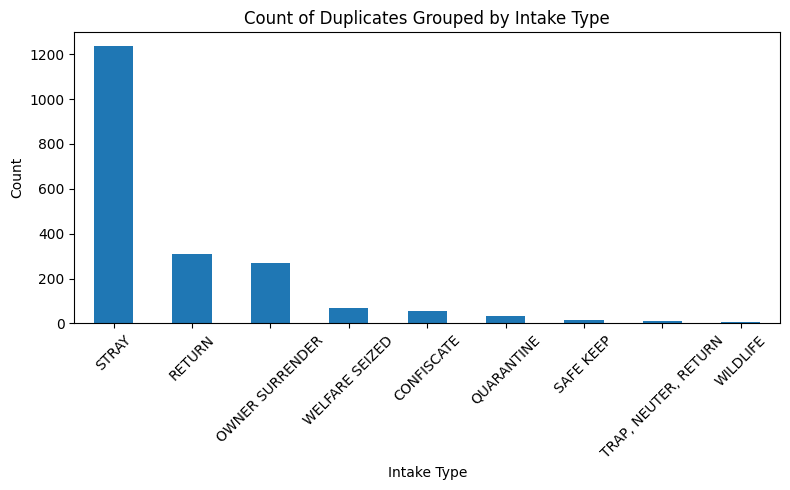

In [12]:
# 1. Histogram: count of duplicates grouped by intake_type
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_type'].value_counts().plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Count of duplicates by outcome type

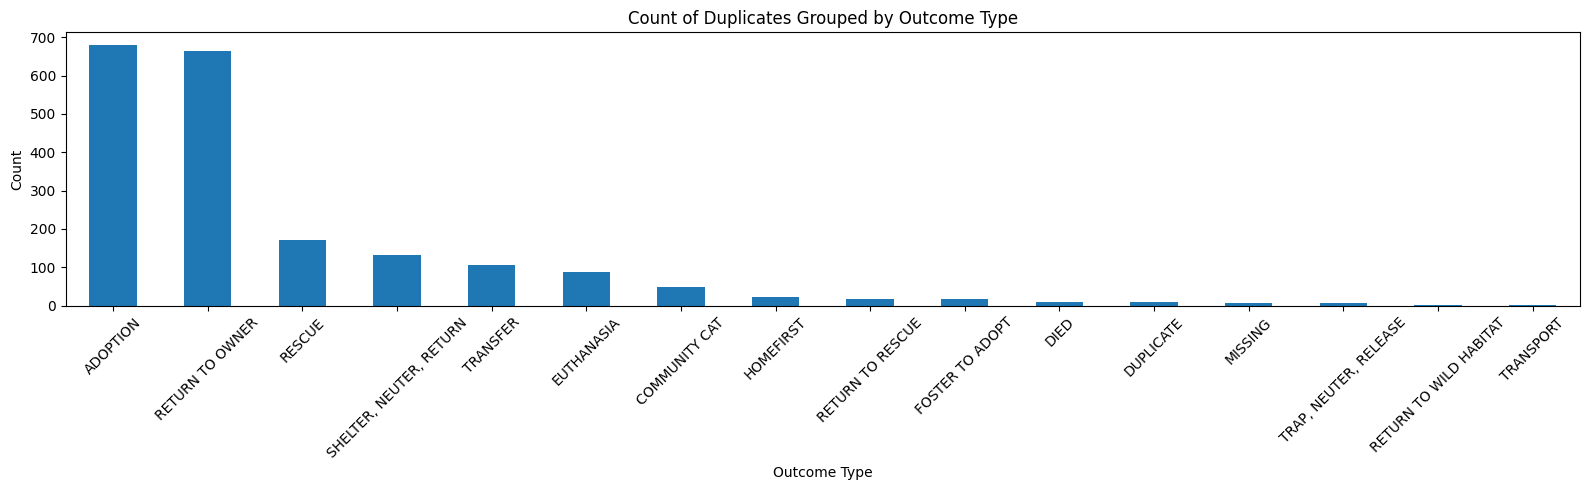

In [13]:
# 2. Histogram: count of duplicates grouped by outcome_type
plt.figure(figsize=(16, 5))
duplicates_grouped['outcome_type'].value_counts().plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Count of duplicates by intake condition

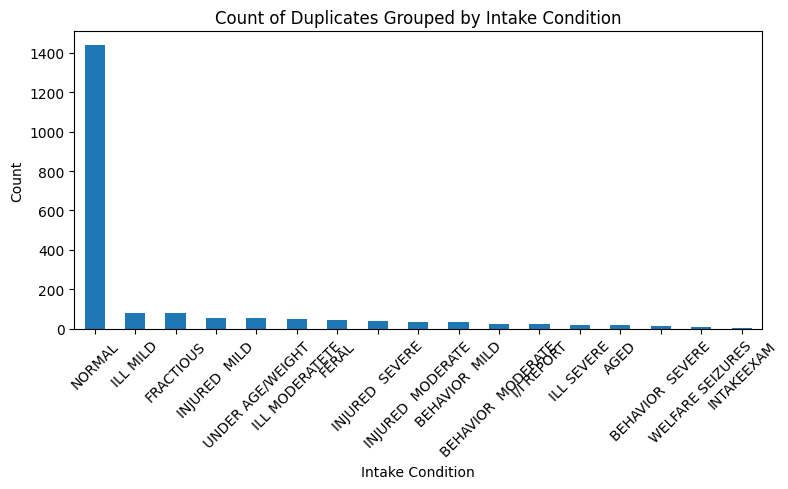

In [14]:
# 3. Histogram: count of duplicates grouped by intake_cond
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_cond'].value_counts().plot(kind='bar')
plt.xlabel('Intake Condition')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Find all animal_ids that are duplicated
duplicate_counts = df['animal_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

# Create a DataFrame with animal_id and number of duplicates
duplicates_summary = duplicate_counts.reset_index()
duplicates_summary.columns = ['animal_id', 'number_of_duplicates']

In [16]:
duplicates_summary.describe()

,number_of_duplicates
count,910.000000
mean,2.193407
std,0.604312
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,8.000000


Insights about returned animals:
1. Most returned animals are returned twice
2. 944 animals were returned
3. Most returned animals were normal upon intake
4. 132 animals have returned more than twice

In [17]:
duplicates_summary[duplicates_summary['number_of_duplicates'] > 2]

,animal_id,number_of_duplicates
0,A637086,8
1,A637269,7
2,A593031,7
3,A279626,6
4,A610057,6
...,...,...
116,A577670,3
117,A593827,3
118,A553599,3
119,A664963,3


# Data cleaning & Processing 1

## Datetime conversion

In [18]:
# Convert *dob*, *intake_date*, *outcome_date* to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['intake_date'] = pd.to_datetime(df['intake_date'], errors='coerce')
df['outcome_date'] = pd.to_datetime(df['outcome_date'], errors='coerce')

## Adding time to outcome

In [19]:
df['time_to_outcome'] = df['outcome_date'] - df['intake_date'] # Calculate time to outcome in days

## Dealing with duplicates

In [20]:
df = df.sort_values(['animal_id', 'intake_date'])

In [21]:
# Create visit_count using groupby and cumcount
df['visit_count'] = df.groupby('animal_id').cumcount() + 1

In [22]:
# Additional useful features
df['is_return_visit'] = (df['visit_count'] > 1).astype(int)
df['is_frequent_returner'] = (df['visit_count'] > 2).astype(int)

In [23]:
# Advanced features for return animals
df['days_since_last_visit'] = df.groupby('animal_id')['intake_date'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(-1)
df['previous_outcome_type'] = df.groupby('animal_id')['outcome_type'].shift(1)
df['previous_outcome_type'] = df['previous_outcome_type'].fillna('First Visit')

# EDA pt. 1

## Return stats

In [24]:
print(f"Visit count distribution:")
print(df['visit_count'].value_counts().sort_index())
print(f"\nReturn visit rate: {df['is_return_visit'].mean():.1%}")
print(f"\nFrequent returner rate: {df['is_frequent_returner'].mean():.1%}")
print(f"\nMean days between visits: {df['days_since_last_visit'].mean():.1f}")
print(f"\nMedian days between visits: {df['days_since_last_visit'].median():.1f}")
print(f"\nMost common previous outcome for returns:")
print(df[df['is_return_visit']==1]['previous_outcome_type'].value_counts().head())

Visit count distribution:
visit_count
1    30851
2      910
3      121
4       30
5       15
6        6
7        3
8        1
Name: count, dtype: int64

Return visit rate: 3.4%

Frequent returner rate: 0.6%

Mean days between visits: 8.0

Median days between visits: -1.0

Most common previous outcome for returns:
previous_outcome_type
RETURN TO OWNER            442
ADOPTION                   387
SHELTER, NEUTER, RETURN    103
TRANSFER                    41
COMMUNITY CAT               33
Name: count, dtype: int64


## Null value analysis

In [25]:
# Percentage of null values in each column
df.isnull().mean()*100

animal_id                 0.000000
animal_name              40.714532
animal_type               0.000000
primary_color             0.000000
secondary_color          52.353070
sex                       0.000000
dob                      12.496477
intake_date               0.000000
intake_cond               0.000000
intake_type               0.000000
intake_subtype            1.296302
reason                   93.199111
outcome_date              0.526036
crossing                  0.000000
jurisdiction              0.000000
outcome_type              0.544823
outcome_subtype          11.190782
latitude                  0.000000
longitude                 0.000000
intake_is_dead            0.000000
outcome_is_dead           0.000000
was_outcome_alive         0.000000
geopoint                  0.000000
time_to_outcome           0.526036
visit_count               0.000000
is_return_visit           0.000000
is_frequent_returner      0.000000
days_since_last_visit     0.000000
previous_outcome_typ

## MSNO matrix

<Axes: >

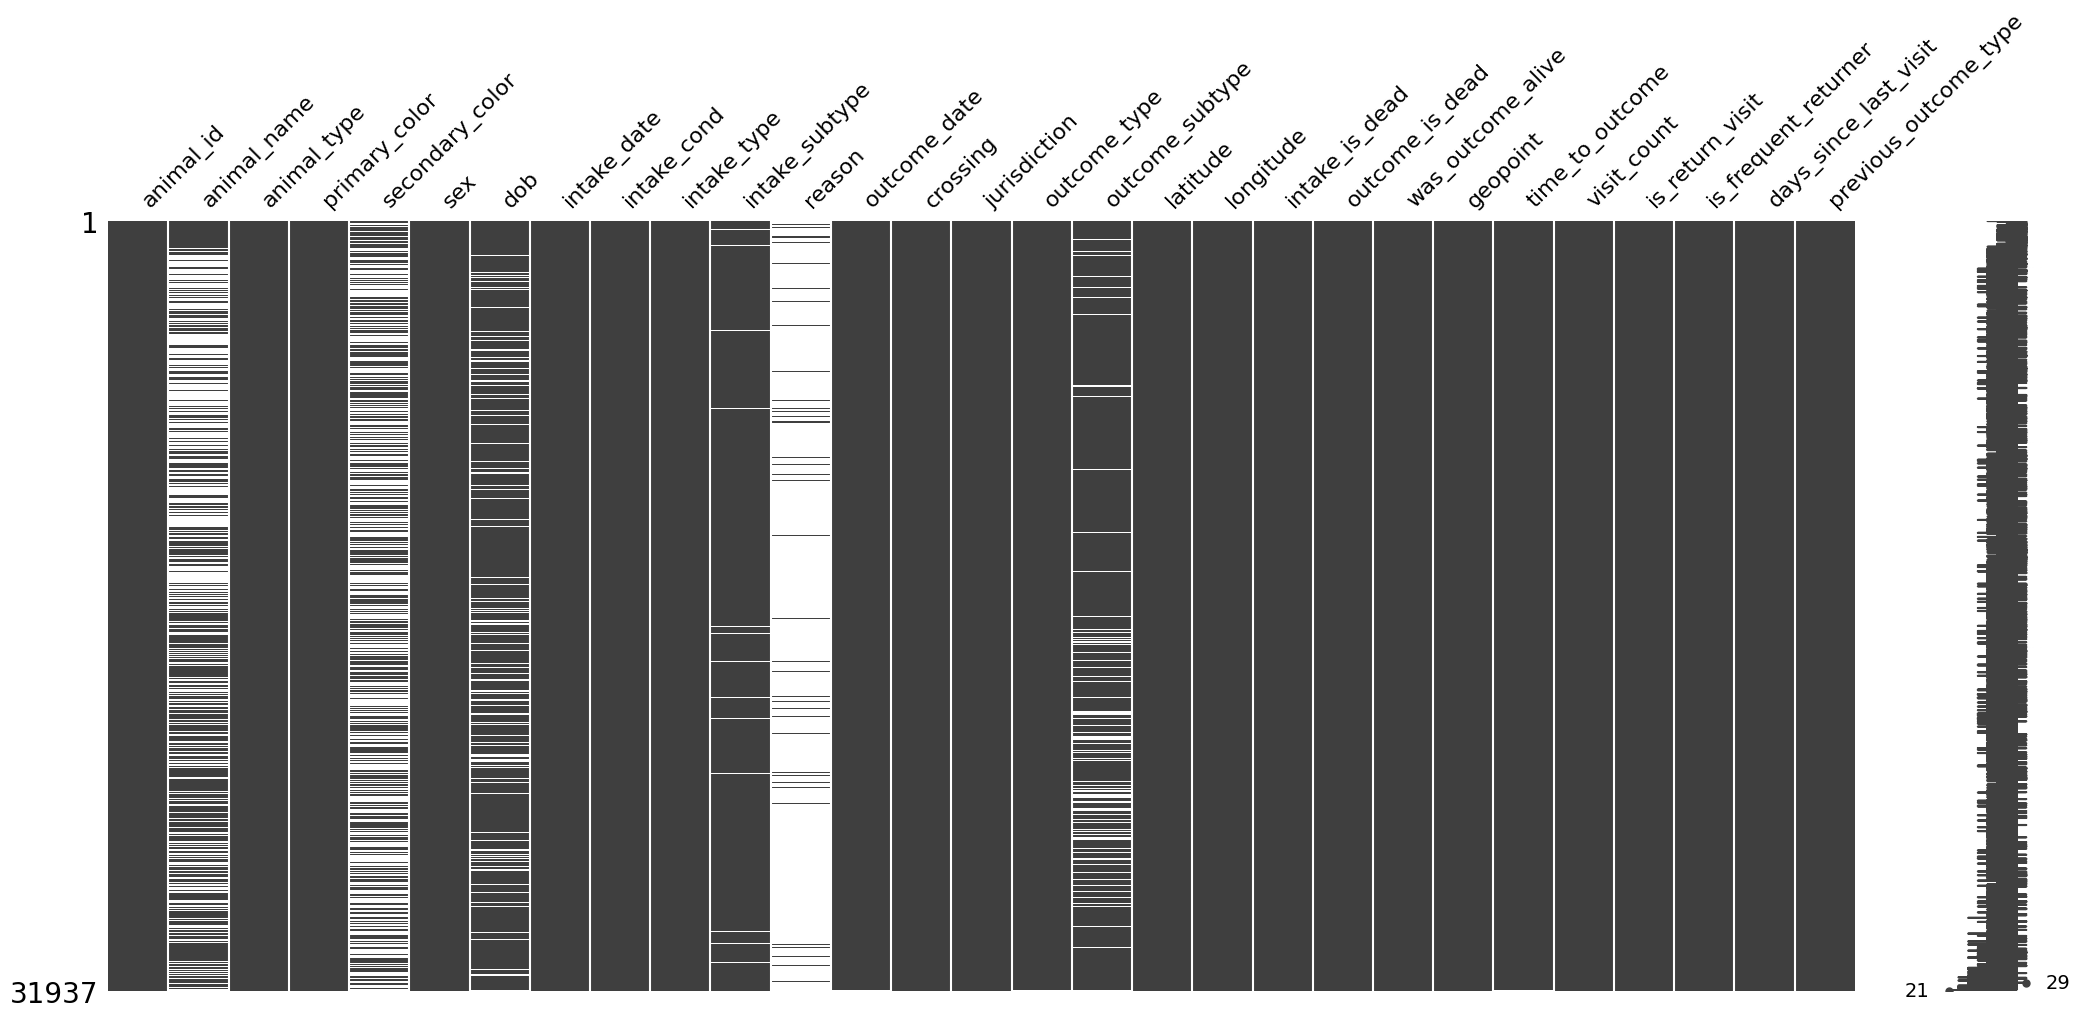

In [26]:
matrix(df)

## Outcome type count

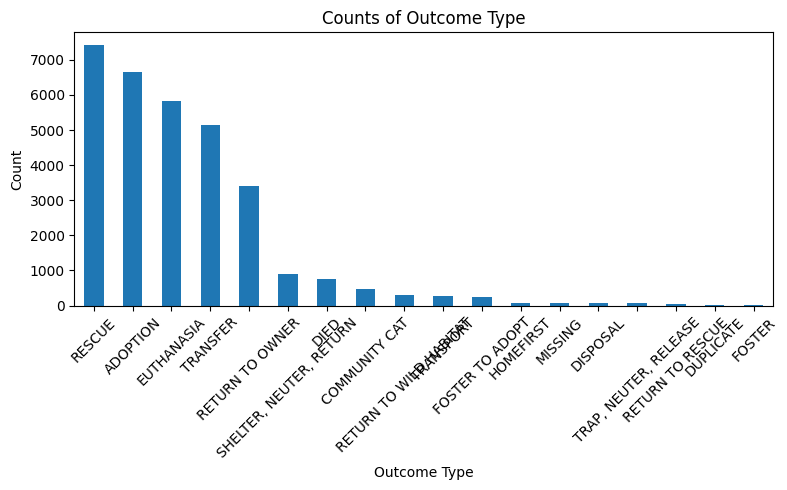

In [27]:
# Get value counts for outcome_type
counts = df['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Animal type counts

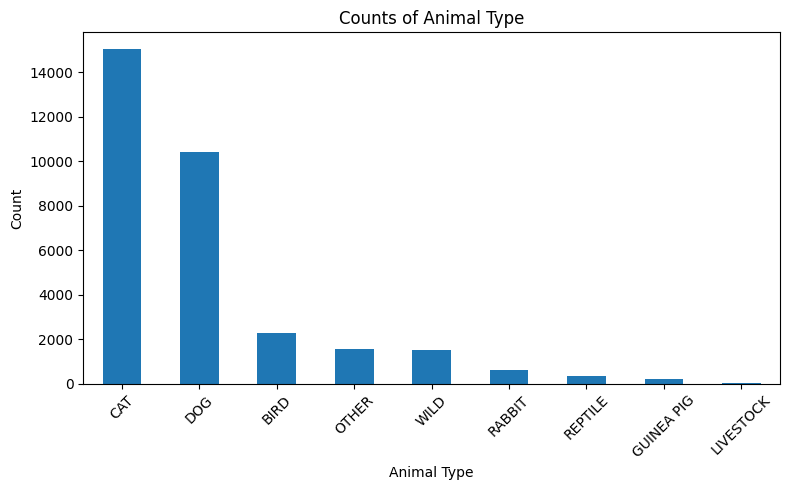

In [28]:
# Get value counts for animal_type
counts = df['animal_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Counts of Animal Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intake type count

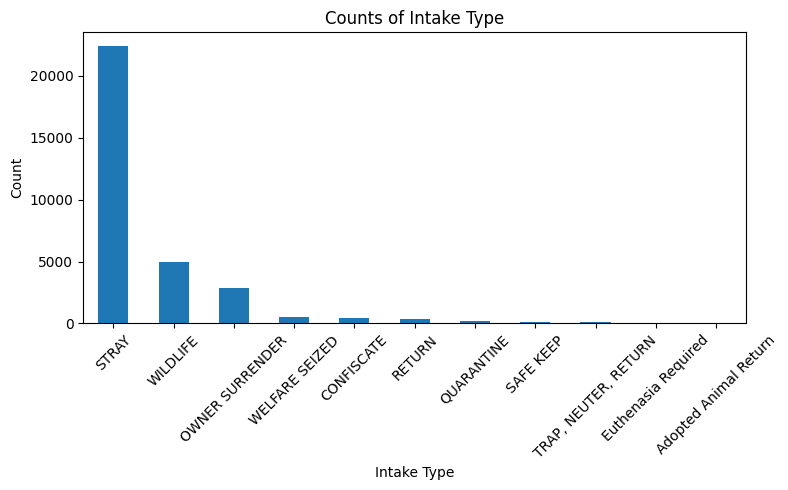

In [29]:
# Get value counts for intake_type
counts = df['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DOB null grouped by intake type

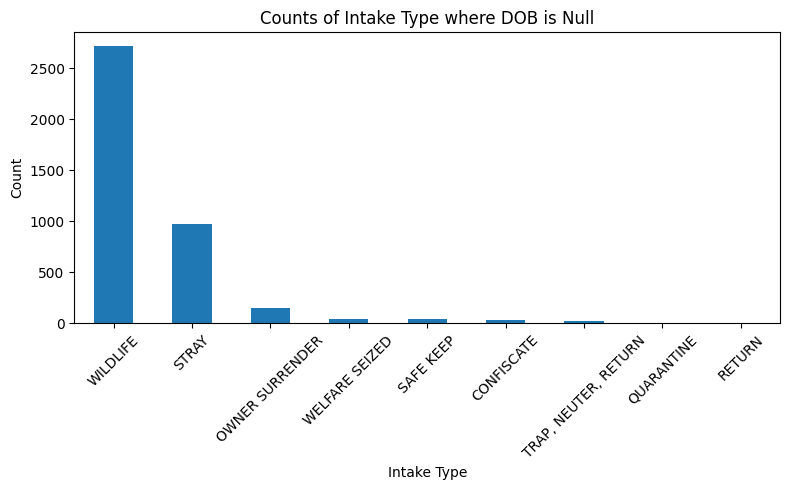

In [30]:
# Filter rows where dob is null
null_dob = df[df['dob'].isnull()]

# Get value counts for intake_type in these rows
counts = null_dob['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type where DOB is Null')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
counts.head(10)

intake_type
WILDLIFE                2717
STRAY                    978
OWNER SURRENDER          151
WELFARE SEIZED            44
SAFE KEEP                 38
CONFISCATE                34
TRAP, NEUTER, RETURN      23
QUARANTINE                 3
RETURN                     3
Name: count, dtype: int64

# Data cleaning & Processing 2

## Statistical/Domain-knowledge based imputation for DOB

In [32]:
def impute_dob_statistical(df):
    """Impute DOB using statistical measures from similar animals"""
    df_imputed = df.copy()
    
    # Calculate age for animals with known DOB
    known_mask = df_imputed['dob'].notna()
    df_imputed.loc[known_mask, 'age_at_intake_days'] = (
        df_imputed.loc[known_mask, 'intake_date'] - df_imputed.loc[known_mask, 'dob']
    ).dt.days
    
    # Group by animal_type and intake_type for imputation
    imputation_groups = ['animal_type', 'intake_type', 'sex']
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        # Get characteristics of current animal
        animal_info = df_imputed.loc[idx]
        
        # Find similar animals with known DOB
        similar_animals = df_imputed[
            (df_imputed['animal_type'] == animal_info['animal_type']) &
            (df_imputed['intake_type'] == animal_info['intake_type']) &
            (df_imputed['sex'] == animal_info['sex']) &
            (df_imputed['dob'].notna())
        ]
        
        # If no exact match, broaden the criteria
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['intake_type'] == animal_info['intake_type']) &
                (df_imputed['dob'].notna())
            ]
        
        # If still no match, use animal_type only
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['dob'].notna())
            ]
        
        if len(similar_animals) > 0:
            # Use median age of similar animals
            median_age_days = similar_animals['age_at_intake_days'].median()
            
            # FIX: Check if median is valid and convert to int
            if pd.notna(median_age_days):
                # Calculate imputed DOB
                imputed_dob = animal_info['intake_date'] - timedelta(days=int(median_age_days))
                df_imputed.loc[idx, 'dob'] = imputed_dob
                imputed_count += 1
    
    print(f"Strategy 1: Imputed DOB for {imputed_count} animals using statistical method")
    return df_imputed

def impute_dob_domain_knowledge(df):
    """Impute DOB using domain knowledge about animal shelters"""
    df_imputed = df.copy()
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        animal_info = df_imputed.loc[idx]
        intake_date = animal_info['intake_date']
        
        # Define typical ages based on intake type and condition
        if animal_info['intake_type'] == 'WILDLIFE':
            # Wildlife often comes in as injured adults or orphaned babies
            if 'WEIGHT' in str(animal_info['intake_cond']).upper():
                # Likely a baby if underweight
                estimated_age_days = np.random.normal(30, 15)  # 1 month ± 2 weeks
            else:
                # Likely adult wildlife
                estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
                
        elif animal_info['intake_type'] == 'STRAY':
            # Strays are often young adults who got lost
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(548, 365)  # 1.5 years ± 1 year
            else:  # DOG
                estimated_age_days = np.random.normal(730, 365)  # 2 years ± 1 year
                
        elif animal_info['intake_type'] == 'OWNER SURRENDER':
            # Owner surrenders often older animals due to life changes
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(1095, 730)  # 3 years ± 2 years
            else:  # DOG
                estimated_age_days = np.random.normal(1460, 1095)  # 4 years ± 3 years
                
        else:
            # Default for other types
            estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
        
        # Ensure positive age and not born in the future
        estimated_age_days = max(1, estimated_age_days)
        estimated_age_days = min(estimated_age_days, 5475)  # Max 15 years
        
        # FIX: Convert to int for timedelta
        # Calculate DOB
        imputed_dob = intake_date - timedelta(days=int(estimated_age_days))
        df_imputed.loc[idx, 'dob'] = imputed_dob
        imputed_count += 1
    
    print(f"Strategy 2: Imputed DOB for {imputed_count} animals using domain knowledge")
    return df_imputed

def impute_dob_hybrid(df):
    """Combine multiple strategies for best results"""
    df_imputed = df.copy()
    
    print("Hybrid DOB Imputation Strategy:")
    print("=" * 40)
    
    # First, try statistical imputation for animals with many similar examples
    df_imputed = impute_dob_statistical(df_imputed)
    
    # Then, use domain knowledge for remaining missing values
    remaining_missing = df_imputed['dob'].isna().sum()
    if remaining_missing > 0:
        print(f"Applying domain knowledge to {remaining_missing} remaining missing DOBs")
        df_imputed = impute_dob_domain_knowledge(df_imputed)
    # Calculate age for ALL animals after imputation
    df_imputed['age_at_intake_days'] = (df_imputed['intake_date'] - df_imputed['dob']).dt.days
    
    return df_imputed

In [33]:
df = impute_dob_hybrid(df)

Hybrid DOB Imputation Strategy:


/Users/atharvavyas/Library/Caches/pypoetry/virtualenvs/community-capstone-X1y0cgVF-py3.11/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/atharvavyas/Library/Caches/pypoetry/virtualenvs/community-capstone-X1y0cgVF-py3.11/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/atharvavyas/Library/Caches/pypoetry/virtualenvs/community-capstone-X1y0cgVF-py3.11/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/atharvavyas/Library/Caches/pypoetry/virtualenvs/community-capstone-X1y0cgVF-py3.11/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Strategy 1: Imputed DOB for 3969 animals using statistical method
Applying domain knowledge to 22 remaining missing DOBs
Strategy 2: Imputed DOB for 22 animals using domain knowledge


## Deleting values where DOB > intake_date

In [34]:
df = df[(df['dob'] <= df['intake_date']) | df['dob'].isnull() | df['intake_date'].isnull()]

## Replace null values of secondary colour

In [35]:
df['secondary_color'] = df['secondary_color'].fillna('None')

## Dropping columns *reason*, *geopoint*, *was_outcome_alive*, *animal_id*

In [36]:
df = df.drop(columns=['reason', 'geopoint', 'was_outcome_alive', 'animal_id'], axis=1)

## Adding *has_name* column

In [37]:
# New column called has_name where if animal_name is not null, then 1, else 0
df['has_name'] = df['animal_name'].notnull().astype(int)

## Drop *animal_name* column

In [38]:
df = df.drop(columns=['animal_name'])

## Dropping null values for *outcome_type*, & *intake_subtype*

In [39]:
df = df.dropna(subset=['intake_subtype', 'outcome_type'])

## Dropping *crossing*

In [40]:
df = df.drop(columns=['crossing'])

## Dropping *intake_is_dead* column

In [41]:
# Unique values in intake_is_dead
df['intake_is_dead'].unique()

array(['Alive on Intake'], dtype=object)

Can drop this column since no information is being conveyed through only 1 possible outcome here.

In [42]:
df = df.drop(columns=['intake_is_dead'], axis=1)

## Outcome_subtype Null value counts for outcome_type

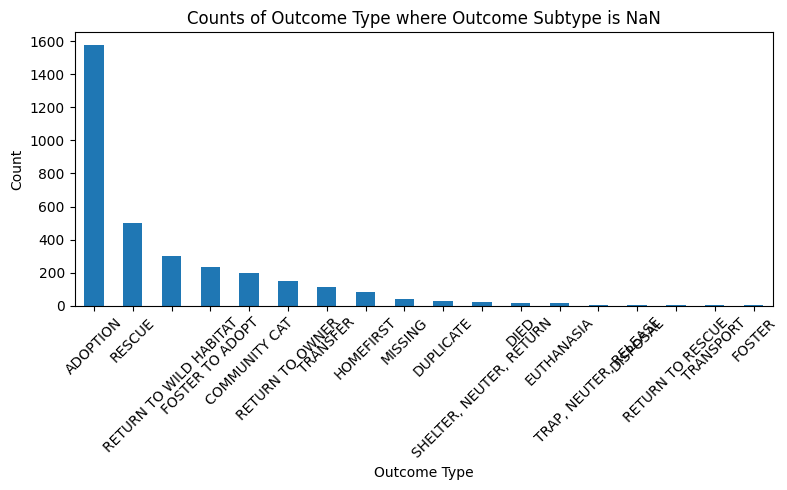

In [43]:
# Get the counts
counts = df[df['outcome_subtype'].isnull()]['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type where Outcome Subtype is NaN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Adding *intake_month*

In [44]:
df['intake_month'] = df['intake_date'].dt.month

## Adding *is_fixed* column

In [45]:
df['is_fixed'] = df['sex'].str.contains('Spayed|Neutered', case=False, na=False).astype(int)

## Making changes to the *sex* column

Since the sex column contains the fix status, we want to change that to just male, female, and unknown options. The way we can do that is by changing "neutered" to male and "spayed" to female

In [46]:
df['sex'] = df['sex'].replace({'Neutered': 'Male', 'Spayed': 'Female'})

# Observations, changes, & notes

1. Drop the following columns: *reason*, *geopoint*, *was_outcome_alive*, *animal_id*
2. Add a *has_name* column, then drop *animal_name*
3. Replace null values in *secondary_color* to "None" so that data for animals with more colours is preserved
4. Drop missing values for *outcome_type*, *intake_subtype*, 
5. Replace missing values in *outcome_subtype* to most commonly occuring values, **after more exploration**
6. Once incorporated into LUCA, drop *latitude*, *longitude*. Use *jurisdiction*
7. Drop *crossing*, unless it helps in geospatial mapping
8. Add a *time_to_outcome* variable
9. Convert *dob*, *intake_date*, *outcome_date* to datetime
10. *outcome_date*, and *outcome_type* have values missing together. Some values in *outcome_subtype* also miss when *outcome_type* is missing.
11. Since target variable is *outcome_type*, dropping *outcome_subtype* makes sense
12. If *outcome_type* is target, remove forward looking variables like *outcome_subtype*, *time_to_outcome*, *outcome_is_dead*, *outcome_date*, 
13. Add *time_at_shelter* but carefully so as to not leak forward looking information
14. Bucket *animal_type* into cat, dog, other
15. Add *age_at_intake* column
16. Add *age_at_outcome* column

# EDA pt. 2

## Average/Median time to outcome grouped by outcome type

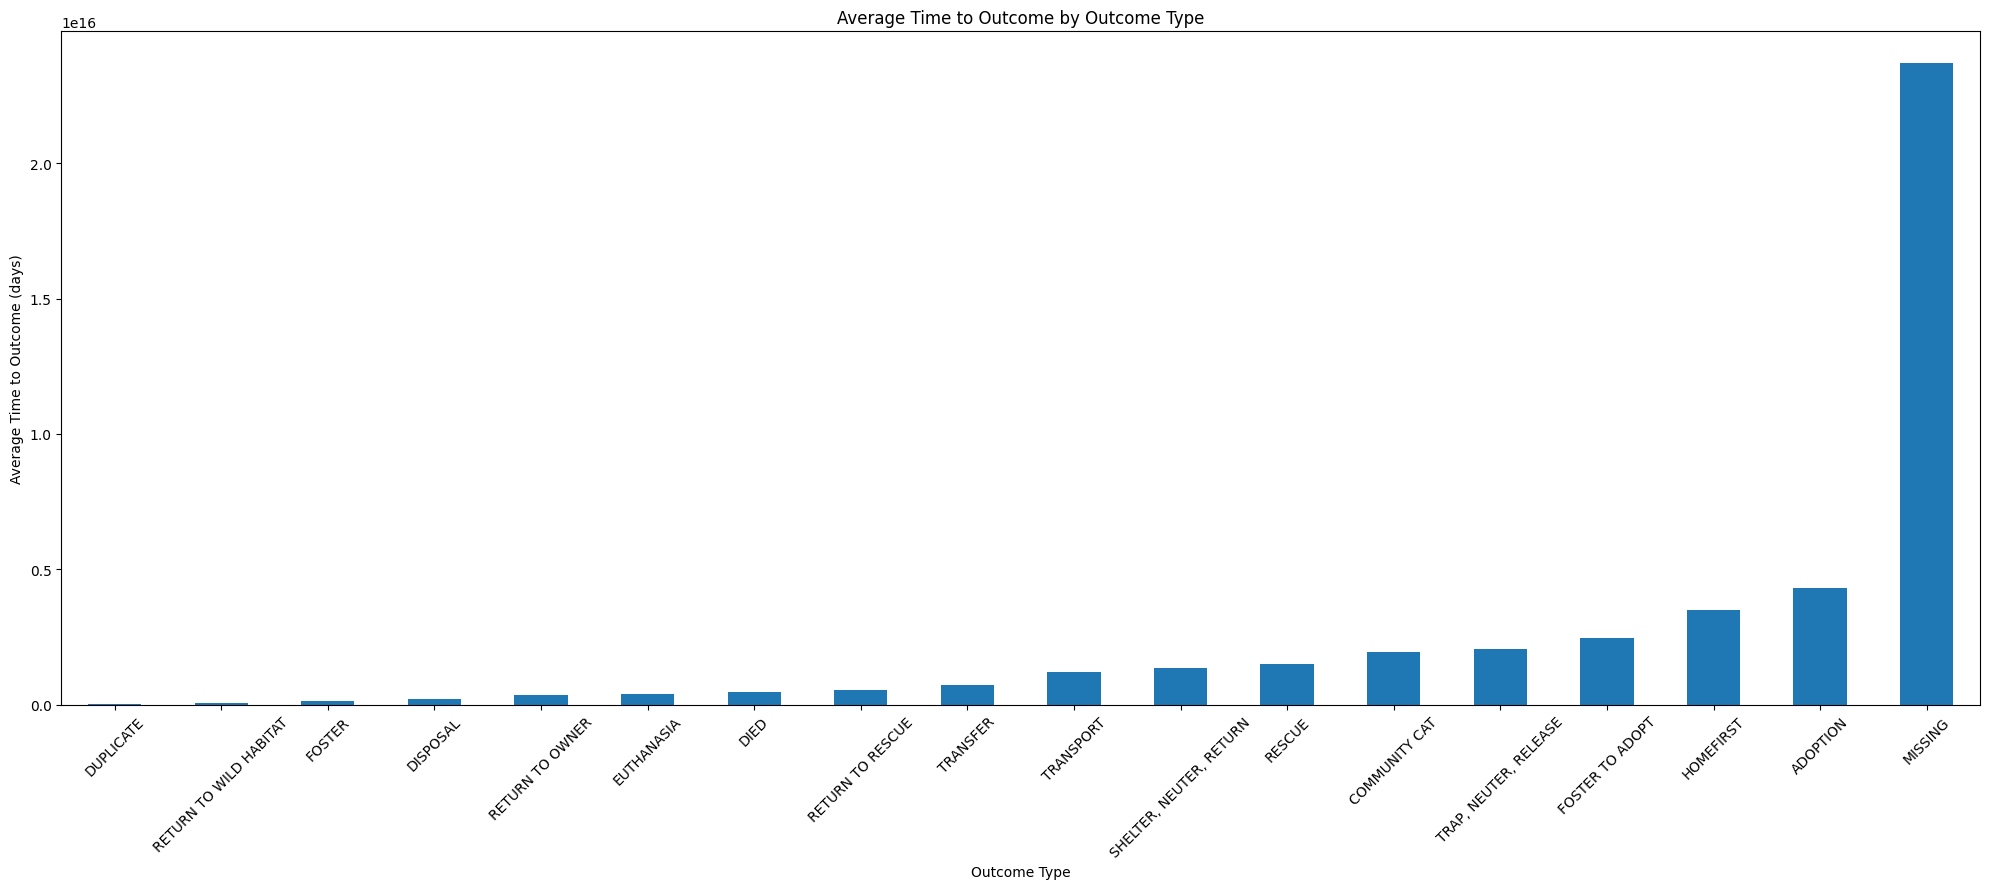

In [47]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].mean().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

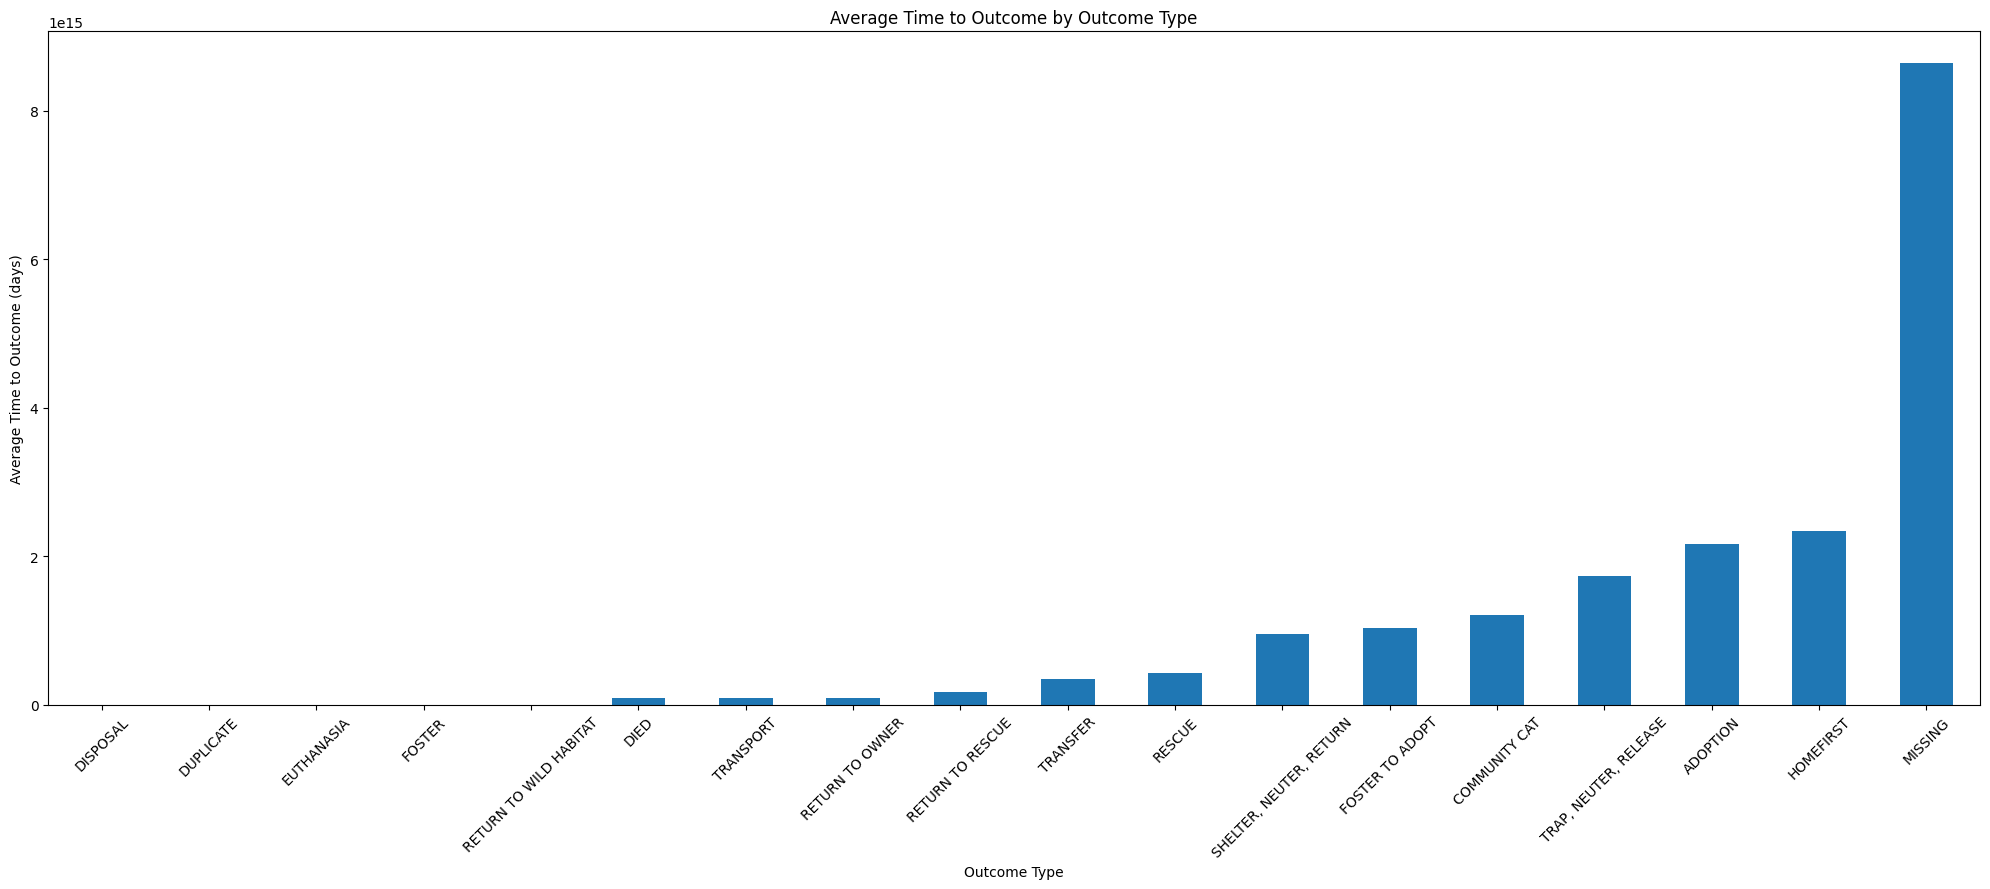

In [48]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].median().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df.head()

,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,outcome_date,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,intake_month,is_fixed
9264,DOG,TRICOLOR,None,Female,2006-08-21,2021-06-11,AGED,STRAY,FIELD,2021-06-12,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1 days,1,0,0,-1.0,First Visit,5408,1,6,1
16929,OTHER,GRAY,None,Unknown,2022-04-03,2022-05-16,ILL MODERATETE,WILDLIFE,FIELD,2022-05-17,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1 days,1,0,0,-1.0,First Visit,43,0,5,0
8251,DOG,CREAM,None,Male,2007-04-23,2022-05-27,NORMAL,STRAY,OTC,2022-05-29,LONG BEACH,RETURN TO OWNER,WALKIN,33.806222,-118.195897,False,2 days,1,0,0,-1.0,First Visit,5513,1,5,1
13021,DOG,BR BRINDLE,WHITE,Female,2008-03-05,2018-03-05,NORMAL,OWNER SURRENDER,FIELD,2018-04-09,LONG BEACH,EUTHANASIA,BEH MODERA,33.852426,-118.185916,True,35 days,1,0,0,-1.0,First Visit,3652,1,3,0
14492,DOG,BROWN,None,Female,2013-02-22,2023-02-20,ILL MILD,STRAY,FIELD,2023-02-22,LONG BEACH,RETURN TO OWNER,WALKIN,33.856286,-118.179124,False,2 days,1,0,0,-1.0,First Visit,3650,1,2,1


## Unique value counts for each column

In [50]:
unique_counts_df = df.nunique().reset_index()
unique_counts_df.columns = ['column', 'unique_value_count']
print(unique_counts_df)

                   column  unique_value_count
0             animal_type                   9
1           primary_color                  81
2         secondary_color                  47
3                     sex                   3
4                     dob                5918
5             intake_date                3054
6             intake_cond                  17
7             intake_type                   8
8          intake_subtype                  22
9            outcome_date                3044
10           jurisdiction                  25
11           outcome_type                  18
12        outcome_subtype                 242
13               latitude                9615
14              longitude                9497
15        outcome_is_dead                   2
16        time_to_outcome                 389
17            visit_count                   8
18        is_return_visit                   2
19   is_frequent_returner                   2
20  days_since_last_visit         

In [51]:
df.isnull().sum()

animal_type                 0
primary_color               0
secondary_color             0
sex                         0
dob                         0
intake_date                 0
intake_cond                 0
intake_type                 0
intake_subtype              0
outcome_date                0
jurisdiction                0
outcome_type                0
outcome_subtype          3281
latitude                    0
longitude                   0
outcome_is_dead             0
time_to_outcome             0
visit_count                 0
is_return_visit             0
is_frequent_returner        0
days_since_last_visit       0
previous_outcome_type       0
age_at_intake_days          0
has_name                    0
intake_month                0
is_fixed                    0
dtype: int64